Note: ChatGPT was used throughout the creation of this notebook to better understand libraries and to find ways to optimize code.

In [36]:
! pip install transformers datasets evaluate
! pip3 install emoji==0.6.0

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             precision_recall_curve,
                             roc_curve,
                             auc)

In [38]:
from datasets import (Dataset,
                      DatasetDict)

from transformers import (DataCollatorWithPadding,
                          # AutoModelForSequenceClassification
                          # Trainer,
                          # TrainingArguments,
                          AutoTokenizer,
                          AutoModel,
                          AutoConfig,
                          get_scheduler)
from transformers.modeling_outputs import TokenClassifierOutput

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW

from tqdm.auto import tqdm

import evaluate

from collections import Counter

In [39]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [40]:
raw_df = pd.read_csv('/content/drive/MyDrive/one_post_per_row.csv')
raw_df.head(5)

,type,post,type_index
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1
2,INFJ,enfp and intj moments https://www.youtube.com...,1
3,INFJ,What has been the most life-changing experienc...,1
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,1


In [41]:
%cd /content/drive/MyDrive/fruits

/content/drive/.shortcut-targets-by-id/1-AdTPjFiouJTFk4KTDPVEUDC8lwsbPDJ/fruits


In [42]:
raw_df['type'].value_counts()

type
INFP    89796
INFJ    72105
INTP    63359
INTJ    52471
ENTP    33761
ENFP    32769
ISTP    16498
ISFP    13000
ENTJ    11273
ISTJ     9913
ENFJ     9288
ISFJ     8121
ESTP     4337
ESFP     2215
ESFJ     2018
ESTJ     1921
Name: count, dtype: int64

In [43]:
mbti_encoding = {
    'INFP': 0, 'INFJ': 1, 'INTP': 2, 'INTJ': 3,
    'ISFP': 4, 'ISFJ': 5, 'ISTP': 6, 'ISTJ': 7,
    'ENFP': 8, 'ENFJ': 9, 'ENTP': 10, 'ENTJ': 11,
    'ESFP': 12, 'ESFJ': 13, 'ESTP': 14, 'ESTJ': 15
}

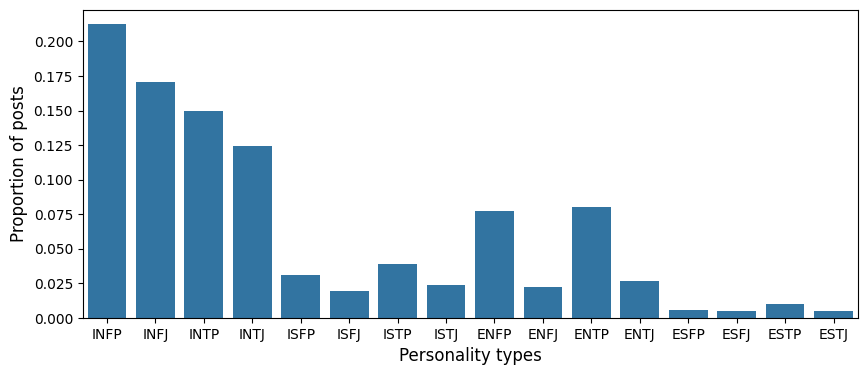

In [44]:
#Plotting this in descending order for better understanding of this visualization
cnt_srs = raw_df['type'].value_counts()
cnt_srs = cnt_srs[mbti_encoding.keys()]
total_samples = cnt_srs.sum()

plt.figure(figsize=(10,4))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values / total_samples)
plt.xlabel('Personality types', fontsize=12)
plt.ylabel('Proportion of posts', fontsize=12)
plt.show()

In [45]:
# bertweet = AutoModel.from_pretrained('vinai/bertweet-large')
# tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-large', use_fast=False)

In [46]:
# save_directory = 'saved'
# tokenizer.save_pretrained(save_directory)
# bertweet.save_pretrained(save_directory)

In [47]:
# Load Bertweet base model
save_directory = 'saved'
bertweet = AutoModel.from_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(save_directory)

In [48]:
df = raw_df.rename(columns={'post': 'sentence', 'type_index': 'label_int', 'type': 'label_str'})
df = df[['sentence', 'label_int', 'label_str']]
df = df.dropna(subset=['sentence'])

In [49]:
dataset = Dataset.from_pandas(df)

# 80% train, 20% test + validation
train_testvalid = dataset.train_test_split(test_size=0.2, seed=15, shuffle=True)

# Split the 20% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5,seed=15, shuffle=True)

# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label_int', 'label_str', '__index_level_0__'],
        num_rows: 337401
    })
    test: Dataset({
        features: ['sentence', 'label_int', 'label_str', '__index_level_0__'],
        num_rows: 42176
    })
    valid: Dataset({
        features: ['sentence', 'label_int', 'label_str', '__index_level_0__'],
        num_rows: 42175
    })
})

In [50]:
model_name = "vinai/bertweet-base"

config = AutoConfig.from_pretrained(model_name, output_attentions=True, output_hidden_states=True)
bertweet_model = AutoModel.from_pretrained(model_name, config=config)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

In [51]:
def tokenize(batch):
    # Tokenize and convert into model-compatible format
    # Choose to omit padding, or change other arguments
    return tokenizer(batch["sentence"], padding=True, truncation=True, max_length=128, return_tensors="pt")

# Takes ~3 minutes
tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset

Map:   0%|          | 0/337401 [00:00<?, ? examples/s]

Map:   0%|          | 0/42176 [00:00<?, ? examples/s]

Map:   0%|          | 0/42175 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label_int', 'label_str', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 337401
    })
    test: Dataset({
        features: ['sentence', 'label_int', 'label_str', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 42176
    })
    valid: Dataset({
        features: ['sentence', 'label_int', 'label_str', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 42175
    })
})

In [52]:
def encode_mbti_label(label):
    encoding = {
        'E': 0, 'I': 1,
        'S': 0, 'N': 1,
        'T': 0, 'F': 1,
        'J': 0, 'P': 1
    }
    return [encoding[c] for c in label]

tokenized_dataset = tokenized_dataset.map(lambda x: {'label_vec': encode_mbti_label(x['label_str'])})

Map:   0%|          | 0/337401 [00:00<?, ? examples/s]

Map:   0%|          | 0/42176 [00:00<?, ? examples/s]

Map:   0%|          | 0/42175 [00:00<?, ? examples/s]

In [53]:
# Converts specified columns into pytorch tensors (may be superfluous)
tokenized_dataset.set_format("torch",columns=["input_ids", "attention_mask", "label_int", "label_vec"])

# Creates data collator object used for batching/data loading?
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [54]:
train_dataloader = DataLoader(
    tokenized_dataset["train"], shuffle=True, batch_size=32, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset["valid"], batch_size=32, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_dataset["test"], batch_size=32, collate_fn=data_collator
)

In [55]:
sample_lens = []
label_strs = []
for i in range(len(tokenized_dataset['train'])):
  sample_lens += [len(tokenized_dataset['train'][i]['input_ids'])]
  label_strs += [tokenized_dataset['train'][i]['label_str']]


KeyError: 'label_str'

In [ ]:
violin_dict = {"type": label_strs, "tokens_per_comment": sample_lens}
violin_df = pd.DataFrame(violin_dict)

num_categories = violin_df['type'].nunique()

plt.figure(figsize=(15,10))
sns.violinplot(x='type', y='tokens_per_comment', data=violin_df, inner=None, color='lightgray')
sns.stripplot(x='type', y='tokens_per_comment', data=violin_df, size=4, jitter=True, palette=sns.color_palette("viridis", num_categories))
plt.ylabel('Tokens per comment')
plt.show()

In [ ]:
%cd /content/drive/MyDrive/fruits

In [ ]:
class BERTweetClassifier(nn.Module):
    def __init__(self, bertweet_model, num_classes=16):
        super(BERTweetClassifier, self).__init__()
        self.bertweet_model = bertweet_model

        self.num_classes = num_classes

        # Hidden size of the BERTweet model
        self.hidden_size = bertweet_model.config.hidden_size

        # Regularization
        self.dropout = nn.Dropout(0.1)

        # Define a fully connected layer for classification
        self.linear1 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.linear2 = nn.Linear(self.hidden_size//2, num_classes)

        # Freeze BERT model parameters
        for param in self.bertweet_model.parameters():
          param.requires_grad = False

        # Unfreeze specific layers, for example, the last 2 transformer layers
        for param in self.bertweet_model.encoder.layer[-2:].parameters():
            param.requires_grad = True


    def forward(self, input_ids, attention_mask=None):
        # Get the outputs from the BERTweet model
        outputs = self.bertweet_model(input_ids=input_ids, attention_mask=attention_mask)

        # outputs.last_hidden_state shape: [batch_size, seq_len, hidden_size]

        last_hidden_state = outputs[0]

        attentions = outputs[1]

        hidden_states = outputs[2]



        # We'll take the [CLS] token representation (first token) as the pooled output
        pooled_output = last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)

        # Pass it through the classification layer
        out = F.relu(self.linear1(pooled_output))
        logits = self.linear2(out)

        return logits, attentions, hidden_states

In [ ]:
checkpoint_dir = "/content/drive/.shortcut-targets-by-id/1-AdTPjFiouJTFk4KTDPVEUDC8lwsbPDJ/fruits"

# INPUT TWEET IS ALREADY NORMALIZED!
model = BERTweetClassifier(bertweet_model)
optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Restore the best validation checkpoint
checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_extra_layer_2.pt")
model.load_state_dict(torch.load(checkpoint_path))
optimizer.load_state_dict(torch.load(checkpoint_path + "optim"))

In [ ]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

model.eval()

progress_bar = tqdm(range(len(eval_dataloader)))

for batch in eval_dataloader:
  batch = {k: v.to(device) for k, v in batch.items()}
  input_ids = batch['input_ids']
  attention_mask = batch['attention_mask']
  labels = batch['label_int']

  with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits, _, _ = outputs

  predictions = torch.argmax(logits, dim=-1)

  accuracy_metric.add_batch(predictions=predictions, references=labels)
  precision_metric.add_batch(predictions=predictions, references=labels)
  recall_metric.add_batch(predictions=predictions, references=labels)
  f1_metric.add_batch(predictions=predictions, references=labels)

  progress_bar.update(1)

accuracy = accuracy_metric.compute()
precision = precision_metric.compute(average='weighted')  # Or 'micro', 'weighted', or None
recall = recall_metric.compute(average='weighted')  # Or another suitable average
f1 = f1_metric.compute(average='weighted')  # Or another suitable average

In [ ]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

model.eval()

all_predictions = []
all_labels = []

progress_bar = tqdm(range(len(eval_dataloader)))

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label_int']

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits, _, _ = outputs

    predictions = torch.argmax(logits, dim=-1)

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    accuracy_metric.add_batch(predictions=predictions, references=labels)
    precision_metric.add_batch(predictions=predictions, references=labels)
    recall_metric.add_batch(predictions=predictions, references=labels)
    f1_metric.add_batch(predictions=predictions, references=labels)

    progress_bar.update(1)

accuracy = accuracy_metric.compute()
precision = precision_metric.compute(average='weighted')  # or other average as required
recall = recall_metric.compute(average='weighted')
f1 = f1_metric.compute(average='weighted')

In [ ]:
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Accuracy:\n", accuracy)
print("Precision:\n", precision)
print("Recall:\n", recall)
print("F1 Score:\n", f1)

In [ ]:
%pwd

In [ ]:
df_2 = pd.read_csv('/content/drive/MyDrive/fruits/str_type_df.csv')
df_2.head()

In [ ]:
all_predictions = df_2['Predicted Type']
all_labels = df_2['Labeled Type']

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/fruits/str_type_df_1.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/fruits/str_type_df_2.csv')
df_3 = pd.read_csv('/content/drive/MyDrive/fruits/str_type_df_3.csv')
df_4 = pd.read_csv('/content/drive/MyDrive/fruits/str_type_df_4.csv')

df_list = [df_1, df_2, df_3, df_4]
strs = ['E vs I:', 'S vs N:', 'F vs T:', 'P vs J:']

for frame, string in zip(df_list, strs):
  print(string)
  all_predictions = frame['Predicted Type']
  all_labels = frame['Labeled Type']

  accuracy = accuracy_score(all_labels, all_predictions)
  precision = precision_score(all_labels, all_predictions, average='weighted')
  recall = recall_score(all_labels, all_predictions, average='weighted')
  f1 = f1_score(all_labels, all_predictions, average='weighted')

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

  # Generate the confusion matrix
  cm = confusion_matrix(all_labels, all_predictions)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_1.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_2.csv')
df_3 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_3.csv')
df_4 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_4.csv')

df_4.head()

In [ ]:
prop_I = df_1['Labeled Type'].sum()/len(df_1['Labeled Type'])
prop_N = df_2['Labeled Type'].sum()/len(df_2['Labeled Type'])
prop_F = df_3['Labeled Type'].sum()/len(df_3['Labeled Type'])
prop_P = df_4['Labeled Type'].sum()/len(df_4['Labeled Type'])
print(f'proportion I: {prop_I}')
print(f'proportion N: {prop_N}')
print(f'proportion F: {prop_F}')
print(f'proportion P: {prop_P}')

len1 = len(df_1['Labeled Type'])
len2 = len(df_2['Labeled Type'])
len3 = len(df_3['Labeled Type'])
len4 = len(df_4['Labeled Type'])
print(f'tot 1: {len1}')
print(f'tot 2: {len2}')
print(f'tot 3: {len3}')
print(f'tot 4: {len4}')


# Precision-Recall Decision Threshold

In [ ]:
def optimize_threshold(df):
  precision, recall, thresholds = precision_recall_curve(df['Labeled Type'], df['Predicted Type'])
  f1_scores = 2 * recall * precision / (recall + precision)
  max_index = np.argmax(f1_scores)
  return thresholds[max_index], f1_scores[max_index]

def plot_confusion_matrix(cm, title, label):
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=label, yticklabels=label)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

# Load data
df_1 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_1.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_2.csv')
df_3 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_3.csv')
df_4 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_4.csv')

threshold_1, f1_1 = optimize_threshold(df_1)
threshold_2, f1_2 = optimize_threshold(df_2)
threshold_3, f1_3 = optimize_threshold(df_3)
threshold_4, f1_4 = optimize_threshold(df_4)

dataframes = [df_1, df_2, df_3, df_4]
thresholds = [threshold_1, threshold_2, threshold_3, threshold_4]
titles = ['E vs I:', 'S vs N:', 'F vs T:', 'P vs J:']
labels = [('E', 'I'), ('S', 'N'), ('T', 'F'), ('J', 'P')]

for df, threshold, title, label in zip(dataframes, thresholds, titles, labels):
  predictions = (df['Predicted Type'] >= threshold).astype(int)
  all_labels = df['Labeled Type']

  print(title)
  print(f'decision threshold: {threshold}')
  accuracy = accuracy_score(all_labels, predictions)
  precision = precision_score(all_labels, predictions, average='weighted')
  recall = recall_score(all_labels, predictions, average='weighted')
  f1 = f1_score(all_labels, predictions, average='weighted')

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

  cm = confusion_matrix(df['Labeled Type'], predictions)
  plot_confusion_matrix(cm, title, label)


In [ ]:
all_df = pd.concat([df_1, df_2, df_3, df_4], axis=1)

In [ ]:
all_df.iloc[:,[0, 2, 4, 6]].values

In [ ]:
all_df = pd.concat([df_1, df_2, df_3, df_4], axis=1)
all_df.iloc[:,[0, 2, 4, 6]].values

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(all_df.values)

plt.figure(figsize=(8, 6))
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c='blue', marker='o', edgecolor='k', s=50)
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
threshold_1, f1_1 = optimize_threshold(df_1)
threshold_2, f1_2 = optimize_threshold(df_2)
threshold_3, f1_3 = optimize_threshold(df_3)
threshold_4, f1_4 = optimize_threshold(df_4)

dataframes = [df_1, df_2, df_3, df_4]
thresholds = [threshold_1, threshold_2, threshold_3, threshold_4]
labels = [('I', 'E'), ('N', 'S'), ('F', 'T'), ('P', 'J')]

for i, (df, threshold) in enumerate(zip(dataframes, thresholds)):
    predictions = (df['Predicted Type'] >= threshold).astype(int)
    df['Character Prediction'] = predictions.apply(lambda x: labels[i][x])
    df['True Label'] = df['Labeled Type'].apply(lambda x: labels[i][x])

final_predictions = pd.concat([df['Character Prediction'] for df in dataframes], axis=1)
labels = pd.concat([df['True Label'] for df in dataframes], axis=1)
final_predictions['MBTI'] = final_predictions.apply(lambda row: ''.join(row), axis=1)
labels['MBTI'] = labels.apply(lambda row: ''.join(row), axis=1)

all_predictions = final_predictions['MBTI']
all_labels = labels['MBTI']

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Decision Threshold

In [ ]:
def optimize_threshold_roc(df):
    fpr, tpr, thresholds = roc_curve(df['Labeled Type'], df['Predicted Type'])
    dist = (1 - tpr)**2 + fpr**2
    max_index = np.argmin(dist)
    return thresholds[max_index], auc(fpr, tpr)

# Load data
df_1 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_1.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_2.csv')
df_3 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_3.csv')
df_4 = pd.read_csv('/content/drive/MyDrive/fruits/prob_df_4.csv')

threshold_1, f1_1 = optimize_threshold_roc(df_1)
threshold_2, f1_2 = optimize_threshold_roc(df_2)
threshold_3, f1_3 = optimize_threshold_roc(df_3)
threshold_4, f1_4 = optimize_threshold_roc(df_4)

dataframes = [df_1, df_2, df_3, df_4]
thresholds = [threshold_1, threshold_2, threshold_3, threshold_4]
titles = ['E vs I:', 'S vs N:', 'F vs T:', 'P vs J:']
labels = [('I', 'E'), ('N', 'S'), ('F', 'T'), ('P', 'J')]

for df, threshold, title, label in zip(dataframes, thresholds, titles, labels):
  predictions = (df['Predicted Type'] >= threshold).astype(int)
  all_labels = df['Labeled Type']

  print(title)
  print(f'decision threshold: {threshold}')
  accuracy = accuracy_score(all_labels, predictions)
  precision = precision_score(all_labels, predictions, average='weighted')
  recall = recall_score(all_labels, predictions, average='weighted')
  f1 = f1_score(all_labels, predictions, average='weighted')

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

  cm = confusion_matrix(df['Labeled Type'], predictions)
  plot_confusion_matrix(cm, title, label)
